In [1]:
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Dark2")

In [2]:
results = pd.read_parquet("./timing_models_scaling_ttf.gzip")
results

,neuroticism,repetition,step,exec_time,ttf,duration,cumulative_duration,model
0,low,1,1,4.319828,0.0,4.319828,4.319828,empirical
1,low,1,2,5.836220,0.0,5.836220,10.156047,empirical
2,low,1,3,4.386451,0.0,4.386451,14.542498,empirical
3,low,1,4,4.679171,0.0,4.679171,19.221669,empirical
4,low,1,5,4.728985,0.0,4.728985,23.950654,empirical
...,...,...,...,...,...,...,...,...
749995,high,30,96,7.487091,5.0,12.487091,1225.834702,theoretical
749996,high,30,97,5.194293,5.0,10.194293,1236.028996,theoretical
749997,high,30,98,8.654080,5.0,13.654080,1249.683076,theoretical
749998,high,30,99,13.702132,5.0,18.702132,1268.385208,theoretical


In [3]:
end_steps = results[(results.step == results.step.max()) & (results.model != "constant")].copy()
end_steps["model"] = end_steps["model"].cat.remove_unused_categories()
end_steps["reference"] = False
end_steps.loc[end_steps["neuroticism"] == "n/a", "reference"] = True
end_steps

,neuroticism,repetition,step,exec_time,ttf,duration,cumulative_duration,model,reference
99,low,1,100,5.687578,0.0,5.687578,558.965547,empirical,False
199,low,2,100,4.393150,0.0,4.393150,502.826977,empirical,False
299,low,3,100,5.453473,0.0,5.453473,500.339581,empirical,False
399,low,4,100,7.041928,0.0,7.041928,506.099676,empirical,False
499,low,5,100,3.697313,0.0,3.697313,473.971834,empirical,False
...,...,...,...,...,...,...,...,...,...
749599,high,26,100,5.766684,5.0,10.766684,1286.747033,theoretical,False
749699,high,27,100,4.296033,5.0,9.296033,1230.981985,theoretical,False
749799,high,28,100,16.388690,5.0,21.388690,1221.906311,theoretical,False
749899,high,29,100,6.030554,5.0,11.030554,1183.486075,theoretical,False


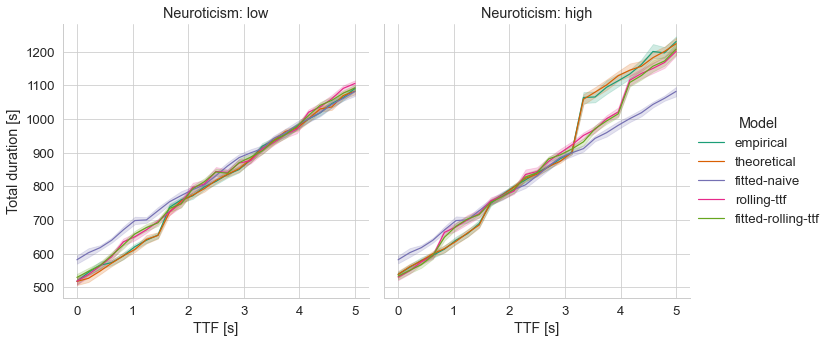

In [4]:
_end_steps = end_steps.copy()

_end_steps["neuro_group"] = "low"
_end_steps.loc[end_steps["neuroticism"] == "high", "neuro_group"] = "high"

na_data = _end_steps.loc[_end_steps["neuroticism"] == "n/a"].copy()
na_data["neuro_group"] = "high"
_end_steps = pd.concat((_end_steps, na_data), ignore_index=True)
_end_steps["neuro_group"] = _end_steps["neuro_group"].astype(pd.CategoricalDtype(["low", "high"], ordered=True))


fg = sns.relplot(
    kind="line",
    data=_end_steps,
    # err_style="bars",
    x="ttf",
    y="cumulative_duration",
    # style="model",
    hue="model",
    col="neuro_group",
    hue_order=["empirical", "theoretical", "fitted-naive", "rolling-ttf", "fitted-rolling-ttf"],
    # hue="neuroticism",
    # col="reference",
    # hue_order=["low", "high", "n/a"],
    # markers=["v", "^", "X"],
    markersize=7,
)
fg.set_axis_labels("TTF [s]", "Total duration [s]")
fg.set_titles("Neuroticism: {col_name}", "")
fg.legend.set_title("Model")
# fg.set(yscale="log")
plt.show()

del _end_steps

In [5]:
max_durations = end_steps[end_steps.ttf == end_steps.ttf.max()].groupby(["model", "neuroticism"], observed=True)["cumulative_duration"].mean()
(max_durations - max_durations[("fitted-naive", "n/a")])/max_durations[("fitted-naive", "n/a")]

model               neuroticism
empirical           low            0.007751
                    high           0.136888
fitted-naive        n/a            0.000000
fitted-rolling-ttf  low            0.009496
                    high           0.115753
naive               n/a           -0.007913
rolling-ttf         low            0.021678
                    high           0.110067
theoretical         low            0.000361
                    high           0.130978
Name: cumulative_duration, dtype: float64

In [6]:
min_durations = end_steps[end_steps.ttf == end_steps.ttf.min()].groupby(["model", "neuroticism"], observed=True)["cumulative_duration"].mean()
(min_durations - min_durations[("fitted-naive", "n/a")])/min_durations[("fitted-naive", "n/a")]

model               neuroticism
empirical           low           -0.109594
                    high          -0.074501
fitted-naive        n/a            0.000000
fitted-rolling-ttf  low           -0.090035
                    high          -0.083115
naive               n/a           -0.003043
rolling-ttf         low           -0.109156
                    high          -0.088126
theoretical         low           -0.110627
                    high          -0.074464
Name: cumulative_duration, dtype: float64

In [7]:
ix = pd.IndexSlice

duration_table = end_steps[(end_steps.ttf == end_steps.ttf.max()) | (end_steps.ttf == end_steps.ttf.min())][["model", "neuroticism", "ttf", "cumulative_duration"]]
duration_table = duration_table.groupby(["model", "neuroticism", "ttf"], observed=True).mean()
duration_table["diff"] = 0.0

def get_diff(s: pd.Series) -> pd.Series:
    ref = s.droplevel(-1)[("fitted-naive", "n/a")]
    return ((s - ref) / ref) * 100.0


duration_table["diff"] = duration_table.groupby("ttf")["cumulative_duration"].apply(get_diff)
duration_table.index.names = ["Model", "Neuroticism", r"\ac{TTF}"]
duration_table = duration_table.rename(columns={"cumulative_duration": "Total Duration", "diff": "Diff. w.r.t. fitted-naive"}).stack()
table_fmt = (
    duration_table
    .loc[
        ix[["fitted-naive", "empirical", "theoretical"]], :
    ]
    .unstack(level=-2)
    .unstack(level=-1)
    .style.format(lambda e: r"\SI{" f"{e:.2f}" r"}{\second}")
    .format(lambda e: ("" if e < 0 else "+") + r"\SI{" f"{e:.2f}" r"}{\percent}",  subset=ix[:, ix[:, "Diff. w.r.t. fitted-naive"]])
)# duration_table.style.format()
# print(duration_table.unstack(level=-2).unstack(level=-1).style.to_latex(siunitx=True))
table_fmt

In [8]:
print(table_fmt.to_latex(siunitx=True, hrules=True, column_format="llrrrr", ))

\begin{tabular}{llrrrr}
\toprule
{} & {\ac{TTF}} & \multicolumn{2}{r}{0.000000} & \multicolumn{2}{r}{5.000000} \\
{} & {} & {Total Duration} & {Diff. w.r.t. fitted-naive} & {Total Duration} & {Diff. w.r.t. fitted-naive} \\
{Model} & {Neuroticism} & {} & {} & {} & {} \\
\midrule
fitted-naive & n/a & \SI{582.07}{\second} & +\SI{0.00}{\percent} & \SI{1082.46}{\second} & +\SI{0.00}{\percent} \\
\multirow[c]{2}{*}{empirical} & low & \SI{518.28}{\second} & \SI{-10.96}{\percent} & \SI{1090.85}{\second} & +\SI{0.78}{\percent} \\
 & high & \SI{538.70}{\second} & \SI{-7.45}{\percent} & \SI{1230.63}{\second} & +\SI{13.69}{\percent} \\
\multirow[c]{2}{*}{theoretical} & low & \SI{517.68}{\second} & \SI{-11.06}{\percent} & \SI{1082.85}{\second} & +\SI{0.04}{\percent} \\
 & high & \SI{538.73}{\second} & \SI{-7.45}{\percent} & \SI{1224.24}{\second} & +\SI{13.10}{\percent} \\
\bottomrule
\end{tabular}



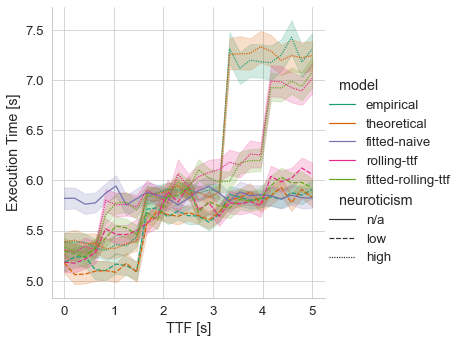

In [9]:
fg = sns.relplot(
    kind="line",
    data=results,
    x="ttf",
    y="exec_time",
    hue="model",
    hue_order=["empirical", "theoretical", "fitted-naive", "rolling-ttf", "fitted-rolling-ttf"],
    style="neuroticism",
)
fg.set_axis_labels("TTF [s]", "Execution Time [s]")
plt.show()

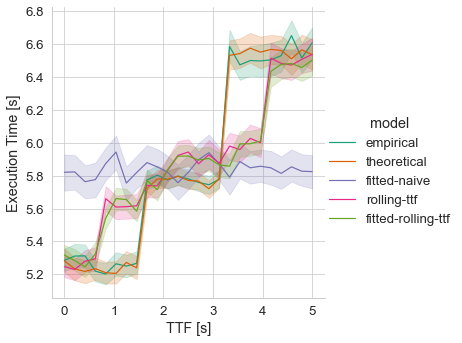

In [10]:
fg = sns.relplot(
    kind="line",
    data=results,
    x="ttf",
    y="exec_time",
    hue="model",
    hue_order=["empirical", "theoretical", "fitted-naive", "rolling-ttf", "fitted-rolling-ttf"],
    # style="neuroticism",
)
fg.set_axis_labels("TTF [s]", "Execution Time [s]")
plt.show()